In [5]:
import yfinance as yf
import pandas as pd

def get_stock_data(tickers):
    data = yf.download(tickers)['Adj Close']
    return data


healthcare_stocks = ['JNJ', 'PFE', 'MRK', 'ABT', 'UNH']
finance_stocks = ['JPM', 'BAC', 'WFC', 'C', 'GS']
tech_stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'CSCO']
consumer_goods_stocks = ['PG', 'KO', 'PEP', 'MCD', 'NKE']

# Combine all selected stocks
all_stocks = healthcare_stocks + finance_stocks + tech_stocks + consumer_goods_stocks

# Get stock data
stock_data = get_stock_data(all_stocks)

# Save the data to a CSV file
stock_data.to_csv('stock_prices.csv')

[*********************100%%**********************]  20 of 20 completed


In [6]:
def calculate_annualized_return(prices):
    daily_returns = prices.pct_change().dropna()
    total_return = (1 + daily_returns).prod() - 1
    annualized_return = (1 + total_return)**(252 / len(daily_returns.index)) - 1  # Assuming 252 trading days in a year
    return annualized_return

def calculate_annualized_volatility(prices):
    daily_returns = prices.pct_change().dropna()
    annualized_volatility = daily_returns.std() * (252**0.5)  # Assuming 252 trading days in a year
    return annualized_volatility

 # Calculate annualized return and volatility for each stock
results = pd.DataFrame(index=all_stocks)
results['Annualized Return'] = stock_data.apply(calculate_annualized_return)
results['Annualized Volatility'] = stock_data.apply(calculate_annualized_volatility)

# Find the stock with the best and worst risk-return profiles
best_stock = results['Annualized Return'].idxmax()
worst_stock = results['Annualized Return'].idxmin()

print("Stock with the Best Risk-Return Profile:", best_stock)
print("Stock with the Worst Risk-Return Profile:", worst_stock)

# Display the results
print("\nResults:")
print(results)

Stock with the Best Risk-Return Profile: AMZN
Stock with the Worst Risk-Return Profile: C

Results:
       Annualized Return  Annualized Volatility
JNJ             0.133751               0.229358
PFE             0.105532               0.274899
MRK             0.124965               0.248549
ABT             0.153023               0.255436
UNH             0.240873               0.398219
JPM             0.119806               0.355109
BAC             0.059130               0.379442
WFC             0.117011               0.331121
C               0.039971               0.401503
GS              0.079815               0.366280
AAPL            0.192292               0.445224
MSFT            0.261333               0.336983
GOOGL           0.230953               0.307376
AMZN            0.317861               0.568146
CSCO            0.223141               0.398785
PG              0.108491               0.213888
KO              0.121596               0.230206
PEP             0.124022            

In [7]:
def analyze_sector_performance(stock_data):
    results = pd.DataFrame(index=stock_data.columns)
    results['Annualized Return'] = stock_data.apply(calculate_annualized_return)
    results['Annualized Volatility'] = stock_data.apply(calculate_annualized_volatility)
    results['Sector'] = results.index.map(get_sector_mapping())

    # Calculate average annualized return and volatility for each sector
    sector_performance = results.groupby('Sector').mean()

    return sector_performance

def get_sector_mapping():
    sector_mapping = {
        'JNJ': 'Healthcare',
        'PFE': 'Healthcare',
        'MRK': 'Healthcare',
        'ABT': 'Healthcare',
        'UNH': 'Healthcare',
        'JPM': 'Finance',
        'BAC': 'Finance',
        'WFC': 'Finance',
        'C': 'Finance',
        'GS': 'Finance',
        'AAPL': 'Tech',
        'MSFT': 'Tech',
        'GOOGL': 'Tech',
        'AMZN': 'Tech',
        'CSCO': 'Tech',
        'PG': 'Consumer Goods',
        'KO': 'Consumer Goods',
        'PEP': 'Consumer Goods',
        'MCD': 'Consumer Goods',
        'NKE': 'Consumer Goods'
    }
    return sector_mapping

# Analyze sector performance
sector_performance = analyze_sector_performance(stock_data)

# Display the results
print("\nSector-wise Performance:")
print(sector_performance)


Sector-wise Performance:
                Annualized Return  Annualized Volatility
Sector                                                  
Consumer Goods           0.133772               0.264421
Finance                  0.083146               0.366691
Healthcare               0.151629               0.281292
Tech                     0.245116               0.411303


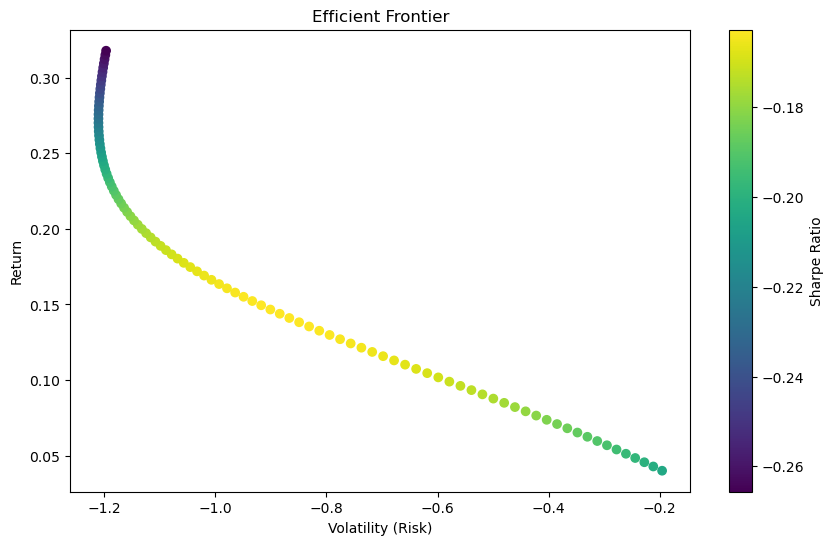

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def calculate_portfolio_metrics(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

def objective_function(weights, returns, cov_matrix, target_return):
    portfolio_return, portfolio_volatility = calculate_portfolio_metrics(weights, returns, cov_matrix)
    # Minimize the negative of the Sharpe ratio to maximize the Sharpe ratio
    return -portfolio_return / portfolio_volatility

def generate_efficient_frontier(returns, cov_matrix, target_returns):
    efficient_frontier = []

    for target_return in target_returns:
        constraints = (
            {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
            {'type': 'eq', 'fun': lambda weights: calculate_portfolio_metrics(weights, returns, cov_matrix)[0] - target_return}
        )

        initial_weights = np.ones(len(returns)) / len(returns)
        result = minimize(objective_function, initial_weights, args=(returns, cov_matrix, target_return),
                          method='SLSQP', constraints=constraints)

        efficient_frontier.append((target_return, result.fun, result.x))

    return efficient_frontier

# Calculate annualized return and volatility for each stock
returns = stock_data.apply(calculate_annualized_return)
cov_matrix = stock_data.pct_change().cov() * 252  # Annualize covariance matrix

# Set target returns for the efficient frontier
target_returns = np.linspace(min(returns), max(returns), num=100)

# Generate the efficient frontier
efficient_frontier = generate_efficient_frontier(returns, cov_matrix, target_returns)

# Extract the returns and volatilities from the efficient frontier results
frontier_returns = [portfolio[0] for portfolio in efficient_frontier]
frontier_volatilities = [portfolio[1] for portfolio in efficient_frontier]

# Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(frontier_volatilities, frontier_returns, c=np.array(frontier_returns) / np.array(frontier_volatilities), cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Return')
plt.show()